In [3]:
!pip install apyori

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5955 sha256=b06c4eb06b82eb438c8adb1aa6a9e7457e2bc17e0e006b74dfa4d27dd4234d26
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [4]:
#Set up and Read the data
import pandas as pd
import sqlite3
from apyori import apriori

In [5]:
df_RFM = pd.read_csv('/content/Basket_dataset.csv')

In [6]:
# connect to database
conn = sqlite3.connect("Market2db")
cur = conn.cursor()

# load CRM data into the RFMdb database
df_RFM.to_sql("rfmdata", conn)

# CHECK IF DATA INSERTED INTO data/RFMdb
df_RFM = pd.read_sql('SELECT * FROM rfmdata', conn)
df_RFM


,index,Member_number,Date,itemDescription
0,0,1808,21/07/2015,tropical fruit
1,1,2552,05/01/2015,whole milk
2,2,2300,19/09/2015,pip fruit
3,3,1187,12/12/2015,other vegetables
4,4,3037,01/02/2015,whole milk
...,...,...,...,...
38760,38760,4471,08/10/2014,sliced cheese
38761,38761,2022,23/02/2014,candy
38762,38762,1097,16/04/2014,cake bar
38763,38763,1510,03/12/2014,fruit/vegetable juice


In [7]:
# group transactions by Customer_ID
cleandata1= pd.read_sql(''' SELECT Member_number,
                   MAX(Date) AS Last_order_date,
                   COUNT(*) AS No_of_Items,
                   COUNT(DISTINCT Date) AS No_of_buskets
            FROM rfmdata
            GROUP BY Member_number ''', conn)

# Write clean CRM data into the database
cleandata1.to_sql("cleandata1", conn)

3898

In [8]:
#clean the data and calculate rfm values
df_RFM = pd.read_sql(''' SELECT Member_number, rfm_recency, rfm_frequency, rfm_monetary, rfm_recency*100 + rfm_frequency*10 + rfm_monetary AS rfm_combined
    FROM
     ( SELECT Member_number,
             NTILE(4) OVER (ORDER BY Last_order_date) AS rfm_recency,
             NTILE(4) OVER (ORDER BY No_of_buskets) AS rfm_frequency,
             NTILE(4) OVER (ORDER BY No_of_Items) AS rfm_monetary
      FROM
            cleandata1
            )
 ''', conn)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def rfm_level(df_RFM):
    if ((df_RFM['rfm_recency'] >= 4) and (df_RFM['rfm_frequency'] >= 4)
        and (df_RFM['rfm_monetary'] >= 4)):
        return 'Best Customers'
    elif ((df_RFM['rfm_recency'] >= 3) and (df_RFM['rfm_frequency'] >= 3)
          and (df_RFM['rfm_monetary'] >= 3)):
        return 'Loyal'
    elif ((df_RFM['rfm_recency'] >= 3) and (df_RFM['rfm_frequency'] >= 1)
          and (df_RFM['rfm_monetary'] >= 2)):
        return 'Potential Loyalist'
    elif ((df_RFM['rfm_recency'] >= 3) and (df_RFM['rfm_frequency'] >= 1)
          and (df_RFM['rfm_monetary'] >= 1)):
        return 'Promising'
    elif ((df_RFM['rfm_recency'] >= 2) and (df_RFM['rfm_frequency'] >= 2)
          and (df_RFM['rfm_monetary'] >= 2)):
        return 'Customers Needing Attention'
    elif ((df_RFM['rfm_recency'] >= 1) and (df_RFM['rfm_frequency'] >= 2)
          and (df_RFM['rfm_monetary'] >= 2)):
        return 'At Risk'
    elif ((df_RFM['rfm_recency'] >= 1) and (df_RFM['rfm_frequency'] >= 1)
          and (df_RFM['rfm_monetary'] >= 2)):
        return 'Hibernating'
    else:
        return 'Lost'

#Create a new variable rfm_level
df_RFM['RFM_level'] = df_RFM.apply(rfm_level, axis=1)
df_RFM


,Member_number,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,RFM_level
0,2828,1,1,1,111,Lost,Lost
1,3197,1,1,1,111,Lost,Lost
2,1238,1,1,1,111,Lost,Lost
3,1436,1,1,1,111,Lost,Lost
4,2297,1,1,1,111,Lost,Lost
...,...,...,...,...,...,...,...
3893,4244,4,3,3,433,Loyal,Loyal
3894,4322,4,3,3,433,Loyal,Loyal
3895,2089,4,4,4,444,Best Customers,Best Customers
3896,4773,4,4,4,444,Best Customers,Best Customers


In [13]:
# Calculate total customers in each segment
RFM_agg = df_RFM.groupby('RFM_level').agg({'Member_number':'count'})
print(RFM_agg)


                             Member_number
RFM_level                                 
At Risk                                454
Best Customers                         341
Customers Needing Attention            726
Hibernating                             70
Lost                                   700
Loyal                                  807
Potential Loyalist                     525
Promising                              275


In [14]:
!pip install squarify

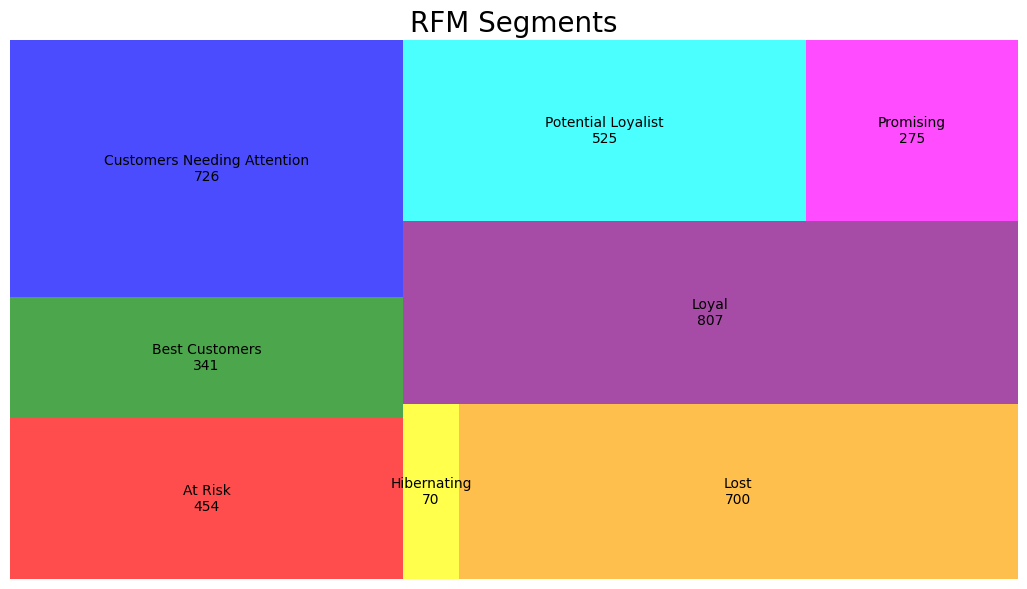

In [16]:
#RFM visualization, you may have to install squarify
import squarify
import matplotlib.pyplot as plt
# Define colors for each segment
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'cyan', 'magenta']

# Combine segment names and corresponding values
labels = [f'{label}\n{value}' for label, value in zip(['At Risk',
                                                       'Best Customers',
                                                       'Customers Needing Attention',
                                                       'Hibernating',
                                                       'Lost',
                                                       'Loyal',
                                                       'Potential Loyalist',
                                                       'Promising'],
                                                      RFM_agg['Member_number'])]

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=RFM_agg['Member_number'],
              label=labels,
              color = colors,
              alpha=0.7),

plt.title("RFM Segments",fontsize=20)
plt.axis('off')
plt.show()


In [17]:
df_RFM

,Member_number,Date,itemDescription
0,1808,21/07/2015,tropical fruit
1,2552,05/01/2015,whole milk
2,2300,19/09/2015,pip fruit
3,1187,12/12/2015,other vegetables
4,3037,01/02/2015,whole milk
...,...,...,...
38760,4471,08/10/2014,sliced cheese
38761,2022,23/02/2014,candy
38762,1097,16/04/2014,cake bar
38763,1510,03/12/2014,fruit/vegetable juice


In [ ]:
#To create associations
#applying apriori algorithm
association_rules = apriori(df_RFM['itemDescription'], min_support=0.0045, min_confidence=0.2, min_lift=3, min_length=2)
association_results = list(association_rules)

In [ ]:
for i in range(0, len(association_results)):
    print(association_results[i][0])